##### Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_absolute_error

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, Dropout 


---
# Time Series Analysis on Avocado Data


In this project, I shall be performing analysis on Avocado price data, using three variations of a LSTM neural network.

*   Model 1: Single LSTM layer
*   Model 2: Two LSTM layers
*   Model 3: Three LSTM layers

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar, and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

*   Date - The date of the observation
*   AveragePrice - the average price of a single avocado
*   type - conventional or organic
*   year - the year
*   Region - the city or region of the observation
*   Total Volume - Total number of avocados sold
*   4046 - Total number of avocados with PLU 4046 sold
*   4225 - Total number of avocados with PLU 4225 sold
*   4770 - Total number of avocados with PLU 4770 sold

The dataset is available at; https://www.kaggle.com/neuromusic/avocado-prices 

In [2]:
#import CSV to dataframe
data = pd.read_csv('/content/avocado.csv', index_col=None, header=0)
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


We seem to have one redundent columns called "unnamed" (possibly used as an ID field), but a mixture of Int, Float and Object types. A break down of which can be seen below.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


Before working with the data, lets check if it needs to be cleaned. We shall do this by Checking for null rows or for duplicate values.

(Spoiler: no missing values, no duplicate entries)



In [4]:
#Count missing values in each column.
data.isna().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [5]:
#duplicate values check
data.duplicated().sum()
data.loc[data.duplicated(keep=False),:]

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region


Since we are only focusing on Average Price, we can drop all the other columns, I have reffered to below project for the train/test splitting process, and use of the function "make_feed_dicts"; https://www.kaggle.com/hastok/lstm-avocado-price-prediction

In [7]:
data = data.drop(['Unnamed: 0', 'Date', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region'],1)

In [8]:
#scale dataet
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [9]:
#function defined for train/test split
#90% training, 10% test
def make_feed_dicts(data,hist_len):
    xs,ys = [],[]
    for i in range(len(data)-hist_len-1):
        ys.append(data[i+hist_len])
        xs.append(data[i:i+hist_len])
    j = int(len(data)*0.9)
    return np.array(xs[:j]),np.array(xs[j:]),np.array(ys[:j]),np.array(ys[j:])

In [10]:
scale_min = min(data)
scale_range = max(data) - scale_min

hist_len = 10
x_train, x_test, y_train, y_test = make_feed_dicts(data, hist_len)
x_test.shape

(1814, 10, 1)

Looking at our x_test dataframe for an example, we have a single dimension frame, with 1814 values in a shape of 10.

Let's feed our three models with our test/train data split. Where each model has an added LSTM layer to compare and evaluate if adding more layers increased the accuracy of our prediciton (while maintaining a low loss). In model two and model three, I have introduced drop out layers between the additional LSTM layers.

---
# Model One: Single LSTM

In [ ]:
# Define the Keras model
model1 = Sequential()

model1.add(LSTM(256, input_shape=(hist_len, 1)))

model1.add(Dense(5, activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Give a summary
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 265,483
Trainable params: 265,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test),shuffle=False)

Epoch 1/10
514/514 [==============================] - 19s 35ms/step - loss: 0.8053 - val_loss: 0.7972
Epoch 2/10
514/514 [==============================] - 17s 34ms/step - loss: 0.7092 - val_loss: 0.7138
Epoch 3/10
514/514 [==============================] - 17s 34ms/step - loss: 0.6659 - val_loss: 0.6754
Epoch 4/10
514/514 [==============================] - 17s 34ms/step - loss: 0.6445 - val_loss: 0.6521
Epoch 5/10
514/514 [==============================] - 18s 34ms/step - loss: 0.6333 - val_loss: 0.6384
Epoch 6/10
514/514 [==============================] - 18s 34ms/step - loss: 0.6266 - val_loss: 0.6291
Epoch 7/10
514/514 [==============================] - 17s 34ms/step - loss: 0.6219 - val_loss: 0.6220
Epoch 8/10
514/514 [==============================] - 17s 34ms/step - loss: 0.6185 - val_loss: 0.6190
Epoch 9/10
514/514 [==============================] - 17s 34ms/step - loss: 0.6155 - val_loss: 0.6114
Epoch 10/10
514/514 [==============================] - 17s 33ms/step - loss: 0.613

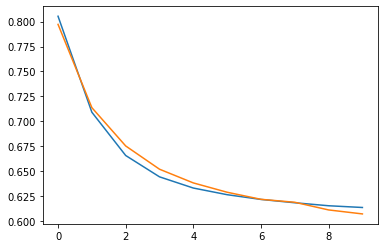

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

Using a single LSTM layer produeces low losses, well relaively, and the curve which represents this is smooth. Can we reduce or improve the loss curve?!

Below represents the accuracy of of our predictions against our actual values, they seem to show relative consitancy and apear to somewhat represent the actual values. However, the predicted values do not as closely follow the magnitude of the actual values, the direction does seem to be consistant.



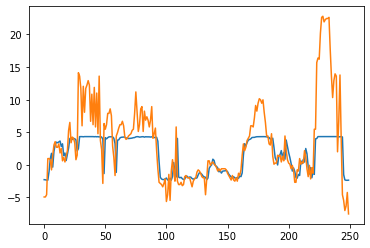

In [ ]:
predicted_x = model1.predict(x_test[:250])
plt.plot(predicted_x*scale_range+scale_min)
plt.plot(y_test[:250].reshape(-1,1)*scale_range+scale_min)

---
# Model Two: Two LSTMs

In [11]:
# Define the Keras model
model2 = Sequential()

model2.add(LSTM(256, input_shape=(hist_len, 1), return_sequences=True))
model2.add(Dropout(0.1))

model2.add(LSTM(256, input_shape=(hist_len, 1)))
model2.add(Dropout(0.1))

model2.add(Dense(5, activation='sigmoid'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
# Give a summary
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 790,795
Trainable params: 790,795
Non-trainable params: 0
__________________________________________________

In [13]:
history2 = model2.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test),shuffle=False)

Epoch 1/15
514/514 [==============================] - 54s 98ms/step - loss: 0.8381 - val_loss: 0.9726
Epoch 2/15
514/514 [==============================] - 49s 95ms/step - loss: 0.8561 - val_loss: 0.9585
Epoch 3/15
514/514 [==============================] - 50s 98ms/step - loss: 0.8395 - val_loss: 0.9643
Epoch 4/15
514/514 [==============================] - 49s 96ms/step - loss: 0.8481 - val_loss: 0.9605
Epoch 5/15
514/514 [==============================] - 49s 96ms/step - loss: 0.8523 - val_loss: 0.9626
Epoch 6/15
514/514 [==============================] - 50s 97ms/step - loss: 0.9587 - val_loss: 1.4010
Epoch 7/15
514/514 [==============================] - 49s 95ms/step - loss: 0.7829 - val_loss: 0.9445
Epoch 8/15
514/514 [==============================] - 49s 96ms/step - loss: 0.7702 - val_loss: 0.9629
Epoch 9/15
514/514 [==============================] - 50s 98ms/step - loss: 0.7570 - val_loss: 0.9281
Epoch 10/15
514/514 [==============================] - 49s 96ms/step - loss: 0.742

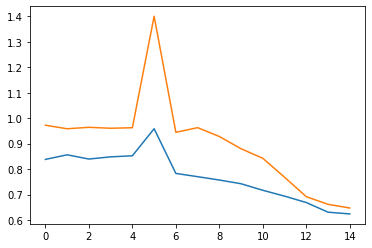

In [14]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

For this model I have changed the epochs and increased them to 15 since initial testing with 10 Epochs hadn't created much visible change in comparison to model one. When the Epochs were kept at 10, the loss and valdiation curve were smoothend. With an increase to 15 we can we a sharp upspike on the 5th Epoch but normalises by the 6th. However, the final loss value is no different to model one or setting Epochs to 10.

Apart from the smoothend loss and loss validation curves, there is not much increase in accuracy which is substantially different than the use of a single layer LSTM. Below represents the accuracy of of our predictions against our actual values. Again, the below graph is very similar to model one, the predicted values do not as closesly follow the magnitude of the actual values, the direction does seem to be consistant.

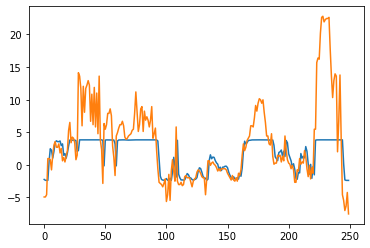

In [15]:
predicted_x = model2.predict(x_test[:250])
plt.plot(predicted_x*scale_range+scale_min)
plt.plot(y_test[:250].reshape(-1,1)*scale_range+scale_min)

---
# Model Three: Three LSTMs

In [16]:
# Define the Keras model
model3 = Sequential()

model3.add(LSTM(256, input_shape=(hist_len, 1), return_sequences=True))
model3.add(Dropout(0.1))

model3.add(LSTM(256, input_shape=(hist_len, 1), return_sequences=True))
model3.add(Dropout(0.1))

model3.add(LSTM(256, input_shape=(hist_len, 1)))
model3.add(Dropout(0.1))

model3.add(Dense(5, activation='sigmoid'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
# Give a summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 256)           264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 256)           525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

In [18]:
history3 = model3.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test),shuffle=False)

Epoch 1/15
514/514 [==============================] - 85s 156ms/step - loss: 0.7623 - val_loss: 0.8027
Epoch 2/15
514/514 [==============================] - 80s 155ms/step - loss: 0.6776 - val_loss: 0.7459
Epoch 3/15
514/514 [==============================] - 80s 155ms/step - loss: 0.6570 - val_loss: 0.7137
Epoch 4/15
514/514 [==============================] - 80s 155ms/step - loss: 0.6440 - val_loss: 0.6910
Epoch 5/15
514/514 [==============================] - 80s 156ms/step - loss: 0.6350 - val_loss: 0.6749
Epoch 6/15
514/514 [==============================] - 83s 161ms/step - loss: 0.6288 - val_loss: 0.6651
Epoch 7/15
514/514 [==============================] - 81s 157ms/step - loss: 0.6249 - val_loss: 0.6493
Epoch 8/15
514/514 [==============================] - 81s 158ms/step - loss: 0.6199 - val_loss: 0.6488
Epoch 9/15
514/514 [==============================] - 80s 156ms/step - loss: 0.6172 - val_loss: 0.6334
Epoch 10/15
514/514 [==============================] - 81s 157ms/step - l

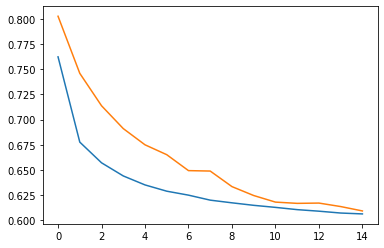

In [19]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

Can a three LSTM layers create any difference?!

With our loss and loss validation curves, there doesnt seem to be as an apparent change, howeverm it seems that our predicted and actual graph below has improved, where the predicited line is following the actualy curve much more closely than model one or model two. However, the predicted does not follow the same magnitude as the actual values.

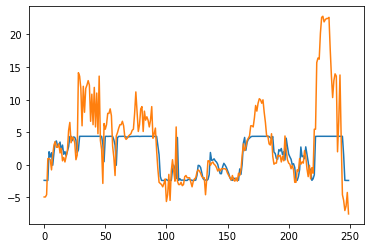

In [20]:
predicted_x = model3.predict(x_test[:250])
plt.plot(predicted_x*scale_range+scale_min)
plt.plot(y_test[:250].reshape(-1,1)*scale_range+scale_min)

---
# Summery

Initially it seemed that a single LSTM layer was sufficient, though, the predicted results are too smooth and dont follow the actual results as well as model three. However, all models come short when reproducing the magnitude of the prediction with the actual results. This is possibly due to the loss being relativly high (especially with model two). If it wasnt for this, then model three would be perfect, however, I feeel that there is scope of improvement in reducing the loss of each model.

It can be said though, that adding more complexity to the model does yeild better prediciton, but this does add to longer trining times, and to what degree will adding more comlexity leade to over-complexity.


It would then be best suggested to stick to model one, though, it would be of benefit to find out if optimising the LSTM nodes themselves can make a difference with the multi-layered nodes. For example, do we need less nodes as we increase the LSTM layers?! Or do we need to optimise our dropout layer or even experiment with a different loss/optimiser algorithm?!

Considering my approach was just focused on average price, was there a different mean I could take from it, maybe involve some other measurement metric?! 